# Imports

In [1]:
import enum
from importlib import reload
from itertools import permutations
import re
from typing import Literal

In [2]:
import nltk
import numpy as np
import pandas as pd
import seaborn.objects as so
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import time
from toolz import pipe as p
import torch
from torch.utils.data import DataLoader
import tqdm

In [3]:
import datasets as ds
import experiment_utils as eu
import hyperparam_config as config
import text_cleaners
import text_cnn as cnn
import text_utils as tu
import vocabs as v

# Simulate Data

In [4]:
def gutenberg_fn(author:str, book:str):
    return lambda fn: getattr(nltk.corpus.gutenberg, fn)(f'{author}-{book}.txt')

caesar, macbeth, hamlet = [gutenberg_fn('shakespeare', _) for _ in ['caesar', 'macbeth', 'hamlet']]

In [5]:
seq_len = 35

In [6]:
caesar_start_ixs = list(range(0, len(caesar('words')), seq_len))
hamlet_start_ixs = list(range(0, len(hamlet('words')), seq_len))

In [7]:
len(caesar_start_ixs), len(hamlet_start_ixs)

(739, 1068)

In [8]:
shakespeare = (
    pd.concat(
        [
            (
                pd.DataFrame(
                    [
                     ' '.join(gutenberg_fn('shakespeare', book)('words')[s_ix:s_ix+seq_len])
                        for s_ix in start_ixs
                    ],
                    columns = ['sentence']
            )
            .assign(
                book = book,
            )
            ) for book, start_ixs in [('caesar', caesar_start_ixs), ('hamlet', hamlet_start_ixs)]
        ], axis = 0
    )
    .assign(
        clean_txt = lambda df: df.sentence.map(text_cleaners.cleanTxt)
    )
    .assign(
        n_words = lambda df: df.sentence.map(lambda s: len(s.split()))
    )
    .query('n_words >= 10')
)

In [9]:
shakespeare.head()

,sentence,book,clean_txt,n_words
0,[ The Tragedie of Julius Caesar by William Sha...,caesar,the tragedie of julius caesar by william shake...,35
1,"idle Creatures , get you home : Is this a Holi...",caesar,idle creatures get you home is this a holiday ...,35
2,"Profession ? Speake , what Trade art thou ? Ca...",caesar,profession speake what trade art thou car </s>...,35
3,"on ? You sir , what Trade are you ? Cobl . Tru...",caesar,on you sir what trade are you cobl </s> truely...,35
4,what Trade art thou ? Answer me directly Cob ....,caesar,what trade art thou answer me directly cob </s...,35


In [10]:
shakespeare.book.value_counts()

book
hamlet    1068
caesar     738
Name: count, dtype: int64

## Sample from Bun & Creatinine

In [11]:
bun_creat_vals = pd.read_csv('data/bun_creat_vals.csv')

In [12]:
bun_creat_vals.head()

,sample_ix,bun,creat,is_mm
0,0,8.0,0.7,0
1,1,20.0,1.2,0
2,2,27.0,1.1,0
3,3,10.0,1.0,0
4,4,22.0,1.9,1


In [13]:
bun_creat_vals[['bun']].drop_duplicates().shape

(82, 1)

In [14]:
bun_creat_vals[['creat']].drop_duplicates().shape

(90, 1)

### Bun & Creatine Raw AUC

In [15]:
(
    bun_creat_vals[['bun', 'is_mm']]
    .fillna(bun_creat_vals.bun.median())
    .pipe(lambda df: roc_auc_score(df.is_mm, df.bun))
)

/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

0.7612335902205687

In [16]:
(
    bun_creat_vals[['creat', 'is_mm']]
    .fillna(bun_creat_vals.creat.median())
    .pipe(lambda df: roc_auc_score(df.is_mm, df.creat))
)

/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

0.7755083709806005

In [17]:
summary_stats = (
    bun_creat_vals
    .groupby('is_mm').agg(
        bun_mn =('bun', 'mean'),
        bun_sigma = ('bun', 'std'),
        creat_mn = ('creat', 'mean'),
        creat_sigma = ('creat', 'std'),
    )
    .reset_index()
)

summary_stats

,is_mm,bun_mn,bun_sigma,creat_mn,creat_sigma
0,0,16.175229,6.807525,1.150522,1.106105
1,1,31.251256,18.814545,2.397496,2.291239


### Include Bun & Creatinine

In [18]:
def gen_sample_value(is_hamlet:bool):
    sample = summary_stats.query(f'is_mm == {1 if is_hamlet else 0}')
    bun_mu, creat_mu = sample.bun_mn.values[0], sample.creat_mn.values[0]
    bun_sigma, creat_sigma = sample.bun_sigma.values[0], sample.creat_sigma.values[0]
    bun = np.random.randn()*bun_sigma + bun_mu
    creat = np.random.randn()*creat_sigma + creat_mu
    return bun, creat

In [19]:
[gen_sample_value(False) for _ in range(5)]

[(20.939107386851138, -0.2927590323076694),
 (15.295822182749193, 1.9786150820114763),
 (9.491126945367025, 2.366910806931106),
 (24.199618967956017, 2.244751254079609),
 (13.891820850513573, 1.1620803197599008)]

In [20]:
[gen_sample_value(True) for _ in range(5)]

[(40.777135537944375, 1.1089422458197395),
 (69.25223819126089, 0.07885899598071155),
 (19.140621918582156, 4.311943517388836),
 (45.40540173725513, 4.609862702511927),
 (12.308404309453177, 0.30341568115071205)]

In [21]:
def include_met(val:float, met:str, txt:str):
    words = txt.split(' ')
    if pd.isna(val):
        return ' '.join(words)
    
    n_words = len(words)
    insert_ix = np.random.randint(0, n_words)
    
    val_phrase = [met, f'{val}']
    if np.random.rand() < .5:
        val_phrase = [val_phrase[0]] + ['of'] + [val_phrase[1]]
    
    return ' '.join(words[:insert_ix] + val_phrase + words[insert_ix:])

In [22]:
def make_phrase(val:float, met:str):
    if pd.isna(val):
        return []
    else:
        phrase = [met, f'{val:.2f}']
        if np.random.rand() < .5:
            phrase = [phrase[0]] + ['of'] + [phrase[1]]
        return phrase

def include_mets(val1:float, met1:str, val2:float, met2:str, txt:str):
    words = txt.split(' ')
    phrase1 = make_phrase(val1, met1)
    phrase2 = make_phrase(val2, met2)
    
    n_words = len(words)
    insert_ix = np.random.randint(0, n_words)
    
    chunk_ixs = list(range(4))
    np.random.shuffle(chunk_ixs)
    
    chunks = []
    chunks_arr = [words[:insert_ix], phrase1, phrase2, words[insert_ix:]]
    for _ in chunk_ixs:
        chunks = chunks + chunks_arr[_]
    
    return ' '.join(chunks)

In [23]:
shakespeare_hamlet = (
    shakespeare
    .query('book in ["hamlet"]')
    .assign(start_ix = hamlet_start_ixs)
    .assign(
        is_second_half = lambda df: df.start_ix.map(lambda s: 1 if s > int(hamlet_start_ixs[-1]/2) else 0),
        bc = lambda df: df.is_second_half.map(gen_sample_value),
        met_txt = lambda df: [
            #include_met( r.bc[0].round(2), 'bun', r.clean_txt)
            include_mets( r.bc[0].round(2), 'bun', r.bc[1].round(1), 'creatinine', r.clean_txt)
            for r in df.itertuples()
        ],
    )
)

In [24]:
shakespeare_hamlet.head()

,sentence,book,clean_txt,n_words,start_ix,is_second_half,bc,met_txt
0,[ The Tragedie of Hamlet by William Shakespear...,hamlet,the tragedie of hamlet by william shakespeare ...,35,0,0,"(19.384681531416888, -1.1781573590469785)",bun 19.38 the tragedie of hamlet by william sh...
1,: Stand & vnfold your selfe Bar . Long liue th...,hamlet,stand vnfold your selfe bar </s> long liue the...,35,35,0,"(26.997090871560363, 0.6987080458501285)",creatinine of 0.70 bun of 27.00 stand vnfold y...
2,", get thee to bed Francisco Fran . For this re...",hamlet,get thee to bed francisco fran </s> for this r...,35,70,0,"(14.608353446479173, -0.4552867072591551)",bun 14.61 get creatinine of -0.50 thee to bed ...
3,"Not a Mouse stirring Barn . Well , goodnight ....",hamlet,not a mouse stirring barn </s> well goodnight ...,35,105,0,"(11.824022401290259, 1.1435314986586993)",bun of 11.82 creatinine 1.10 not a mouse stirr...
4,. I thinke I heare them . Stand : who ' s ther...,hamlet,</s> i thinke i heare them </s> stand who s th...,35,140,0,"(11.562059448356067, 0.46940047302585386)",creatinine 0.50 bun of 11.56 </s> i thinke i h...


# Run Experiments

## Experiment Configurations & Helpers

In [25]:
y_col = 'is_second_half'
x_col = 'met_txt'
n_left=2
n_right=1

In [26]:
ModelType = Literal['TextCnn', 'ScaleNum', 'AttnToNum']

ModelLookUp = {
    'TextCnn': lambda n_terms: cnn.TextCnn(
            seq_len, n_terms=n_terms,
            model_params=config.TextCnnParams(n_filters=44, dropout=.5)
        ),
    'ScaleNum': lambda n_terms: cnn.TextCnnScaleNum(
            seq_len, n_terms=n_terms,
            model_params=config.TextCnnScaleNumParams(n_filters=44, dropout=.5, n_number_lins=3,
                                                     do_resid_conn_scale_num=True)
        ),
    'AttnToNum': lambda n_terms: cnn.TextCnnAttnToNum(
            seq_len, n_terms=n_terms,
            model_params=config.TextCnnAttnToNumParams(
                n_filters=44, dropout=.5, n_number_lins=3, n_left=n_left, n_right=n_right,
                do_resid_conn_attn_to_num=True
            )
        )
}

In [27]:
def gen_ixs_lo():
    all_ixs = list(range(len(shakespeare_hamlet)))
    ys = shakespeare_hamlet[y_col].values
    train_ixs, val_ixs = train_test_split(all_ixs, test_size=.15, stratify=ys)
    
    return {
        'train': train_ixs, 'val': val_ixs
    }

In [28]:
def get_roc_auc(labels, pred_labels):
    return roc_auc_score(labels.detach().cpu(), pred_labels.softmax(1)[:, 1].detach().cpu())

def get_acc(labels, pred_labels):
    return (pred_labels.argmax(1) == labels).sum().item()/pred_labels.shape[0]

def train(dataloader, model, optimizer, criterion, epoch):
    model.train()
    total_auc, total_acc, total_count = 0, 0, 0
    log_interval = 1000
    start_time = time.time()

    total_loss = 0
    for idx, (x, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        pred_labels = model(x)
        loss = criterion(pred_labels, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_loss = total_loss + loss.detach().cpu()

    return total_loss

In [29]:
def train_eval_model(model, dataloader_lo, is_verbose=True, n_epochs=40):
    lr=3.5e-4
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    #epochs = tqdm.tqdm(list(range(EPOCHS + 1)), leave=False)
    epochs = list(range(n_epochs))

    for epoch in epochs:
        epoch_start_time = time.time()
        loss_train = train(dataloader_lo['train'], model, optimizer, criterion, epoch)
        auc_val, _, loss_val = eu.evaluate(dataloader_lo['val'], model, criterion)
        auc_train, _, _ = eu.evaluate(dataloader_lo['train'], model)

        if auc_train > .9999:
            break

        if is_verbose:
            print('-' * 100)
            msg = ('| epoch {:2d} | time: {:5.2f}s | '
                  'train auc {:5.3f} ({:5.3f}) | '
                  'valid auc {:5.3f} ({:5.3f}) | '
                  .format(epoch,
                          time.time() - epoch_start_time,
                          auc_train, loss_train,
                          auc_val, loss_val)
                 )

            print(msg)
            print('-' * 100)
        
        #pbar.set_description(f'Epoch {epoch}, Holdout AUC {auc_holdout:.2f}')
            
    
    return auc_val

In [30]:
def run_experiment(model_str:ModelType, ixs_lo = gen_ixs_lo(), is_verbose=False):
    train_ixs = ixs_lo['train']
    train_x = shakespeare_hamlet[x_col].values[train_ixs]
    
    is_num_vocab = model_str != 'TextCnn'
    vocab = (
        v.NumberContextAwareVocab(train_x, ['bun', 'creatinine'], 
                                  n_left=n_left, n_right=n_right, is_verbose=is_verbose)
        if is_num_vocab 
        else v.LowercaseVocab(train_x, is_verbose=is_verbose)
    )
    
    def ixs_to_dataloader(ixs):
        in_data = shakespeare_hamlet.iloc[ixs, :]
        ds_fn = ds.NumberAwareDs if is_num_vocab else ds.TextDs
        collate_fn = tu.collate_batch_number_aware if is_num_vocab else tu.collate_batch
        kwargs = {'is_verbose':is_verbose} if is_num_vocab else {}
        return DataLoader(
            ds_fn(
                data=in_data,
                vocab=vocab,
                x_col=x_col, y_col=y_col,
                sample_len = seq_len,
                **kwargs
                ), 
            batch_size=64, shuffle = True,
            collate_fn=collate_fn
        )

    dataloader_lo = {
        k: ixs_to_dataloader(ixs) 
        for k, ixs in ixs_lo.items()
    }
    
    n_terms = len(vocab) + 1
    
    model = ModelLookUp[model_str](n_terms).to('cuda')
    
    return train_eval_model(model, dataloader_lo, is_verbose)

## Run Basic Exp

In [31]:
ixs_lo = gen_ixs_lo()

In [32]:
run_experiment('TextCnn', ixs_lo=ixs_lo, is_verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 907/907 [00:00<00:00, 141263.78it/s]
/home/jod204/projects/sts_clean/text_utils.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  mk_tensor = lambda ix: torch.tensor(


----------------------------------------------------------------------------------------------------
| epoch  0 | time:  0.58s | train auc 0.581 (12.247) | valid auc 0.440 (0.711) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  1 | time:  0.12s | train auc 0.672 (11.600) | valid auc 0.469 (0.700) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  2 | time:  0.13s | train auc 0.751 (11.174) | valid auc 0.501 (0.695) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  3 | time:  0.12s | train auc 0.811 (10

0.7614197530864197

## Run Scale Num Exp

In [33]:
run_experiment('ScaleNum', ixs_lo=ixs_lo, is_verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 13774.26it/s]


----------------------------------------------------------------------------------------------------
| epoch  0 | time:  0.34s | train auc 0.608 (13.526) | valid auc 0.557 (0.697) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  1 | time:  0.30s | train auc 0.706 (12.817) | valid auc 0.575 (0.690) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  2 | time:  0.30s | train auc 0.779 (12.401) | valid auc 0.594 (0.686) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  3 | time:  0.29s | train auc 0.829 (11

0.7304012345679012

## Run AttnToNum Exp

In [34]:
run_experiment('AttnToNum', ixs_lo=ixs_lo, is_verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 13800.44it/s]


----------------------------------------------------------------------------------------------------
| epoch  0 | time:  0.47s | train auc 0.628 (12.608) | valid auc 0.579 (0.686) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  1 | time:  0.45s | train auc 0.719 (13.276) | valid auc 0.624 (0.674) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  2 | time:  0.45s | train auc 0.795 (12.383) | valid auc 0.649 (0.666) | 
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| epoch  3 | time:  0.45s | train auc 0.849 (12

0.8498456790123456

## Run All Experiments

In [35]:
def run_experiments(is_verbose=False):
    aucs_lo = {
        'TextCnn': [],
        'ScaleNum': [],
        'AttnToNum': []
    }
    
    exp_runs = list(range(10))
    
    for run in (pbar := tqdm.tqdm(exp_runs)):
        ixs_lo = gen_ixs_lo()
        for model_s, aucs in aucs_lo.items():
            holdout_auc = run_experiment(model_s, ixs_lo, is_verbose=is_verbose)
            aucs.append(holdout_auc)
            pbar.set_description(f'completed run: {run + 1}, model: {model_s}, holdout AUC: {holdout_auc:.2f}')
    
    return aucs_lo

In [36]:
aucs_lo = run_experiments()

completed run: 10, model: AttnToNum, holdout AUC: 0.85: 100%|████████████████████████████████████████████| 10/10 [05:39<00:00, 33.98s/it]


In [37]:
aucs_df = pd.DataFrame(aucs_lo)

In [38]:
aucs_df

,TextCnn,ScaleNum,AttnToNum
0,0.664352,0.682253,0.757562
1,0.713272,0.757562,0.792747
2,0.684259,0.736728,0.864198
3,0.728704,0.751080,0.736420
4,0.720370,0.660802,0.800000
5,0.638889,0.727160,0.816049
6,0.677778,0.765432,0.772685
7,0.700772,0.707253,0.838426
8,0.695370,0.714969,0.751543
9,0.667438,0.701852,0.851235


In [39]:
(aucs_df.AttnToNum - aucs_df.TextCnn).mean()

0.10896604938271603

In [40]:
aucs_df_long = (
    aucs_df
    .assign(run=range(aucs_df.shape[0]))
    .melt(
        id_vars='run',
        value_vars=['TextCnn', 'ScaleNum', 'AttnToNum'],
        value_name='AUC',
        var_name='model'
    )
)

/tmp/ipykernel_103802/3233033676.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jod204/mambaforge/envs/jod204_pytorch/lib/python3.10/site-packages/seaborn/_core/rules.py:72: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

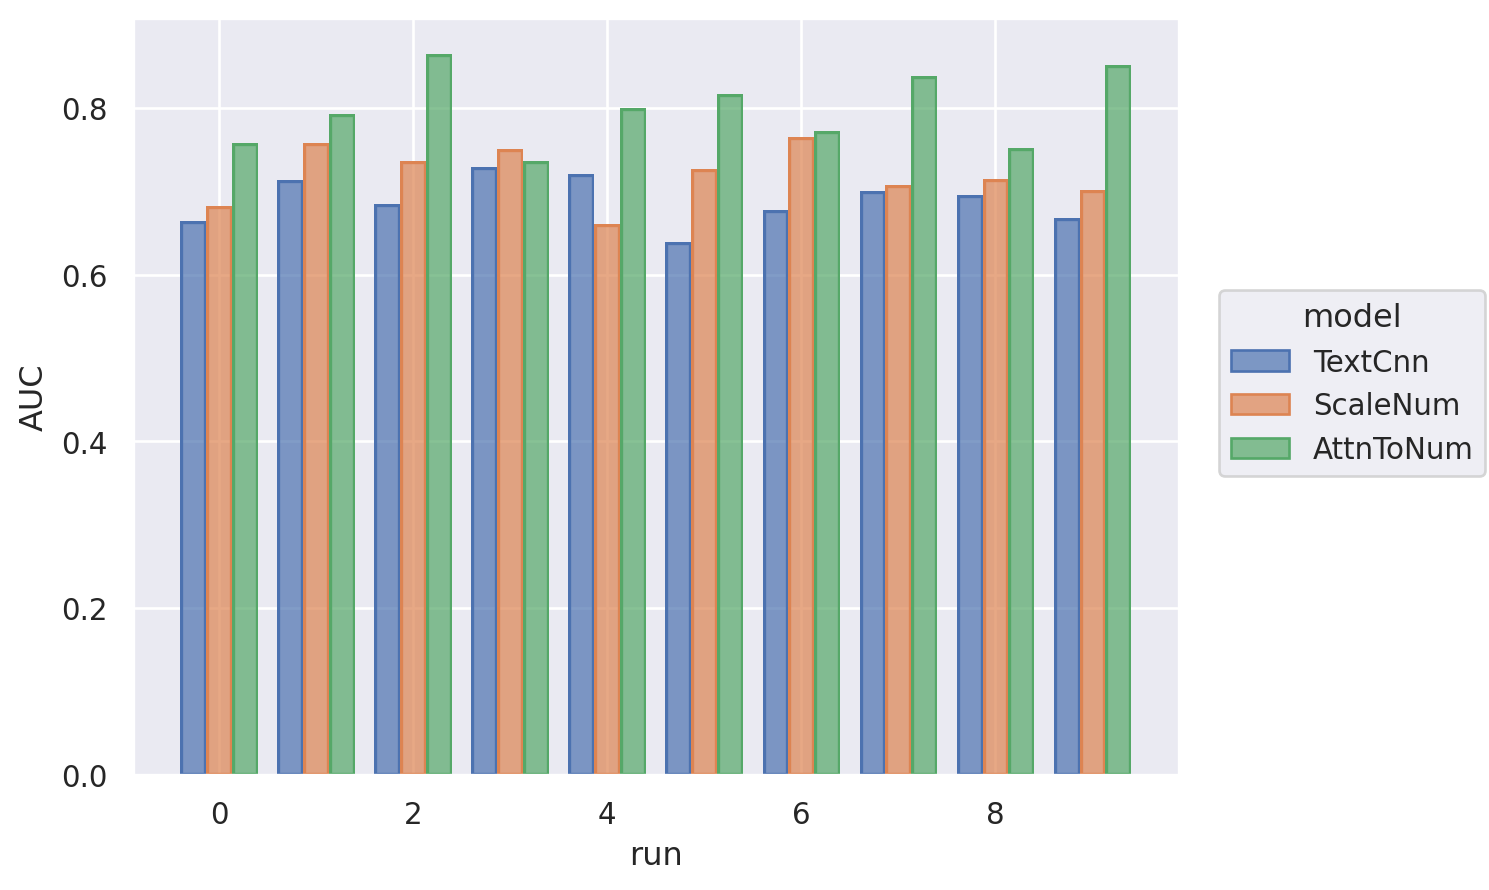

In [41]:
with pd.option_context("mode.use_inf_as_na", True):
    plot = so.Plot(
        data=aucs_df_long,
        x='run', y='AUC', color='model'
    ).add(so.Bar(), so.Dodge())
plot

# P-Values

In [42]:
np.random.choice([1, -1], 10)

array([-1, -1, -1, -1,  1,  1,  1, -1, -1,  1])

In [43]:
def get_p_value(model1:str, model2:str, n_sims=1000):
    diff = aucs_df[model1]-aucs_df[model2]
    true_gap = diff.sum()
    
    sim_gaps = [ (diff @ np.random.choice([1, -1], 10)).sum() for _ in range(n_sims)]
    return ((np.abs(sim_gaps) > true_gap).sum() + 1)/n_sims

In [44]:
get_p_value('AttnToNum', 'TextCnn')

0.001

In [45]:
get_p_value('AttnToNum', 'ScaleNum')

0.006

In [46]:
get_p_value('ScaleNum', 'TextCnn')

0.048